## **Bài tập thu thập dữ liệu (trang tĩnh/động/API)**

- Họ tên: Trần Hoàng Anh Phi
- MSSV: 20120158

<font color=red>Nội dung:</font> 
- Thu thập dữ liệu giá vé máy bay trong các ngày gần nhất ở trang: <href>https://www.vietjetair.com/vi/</href> 
- Tìm giá vé nhỏ nhất từ dữ liệu đã thu thập

##### **Install các package cần thiết**

In [84]:
# %pip install selenium
# %pip install webdriver-manager
# %pip install beautifulsoup4
# %pip install lxml

##### **Import các thư viện**

In [85]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup
import re # Regular expressionc
from datetime import date, timedelta
from time import sleep
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import ElementNotInteractableException

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### **Dùng selenium để thực hiện thao tác đến trang xem giá vé** 

In [86]:
# Mở Chrome và cho full màn hình
# Tự tải phiên bản ChromeDriver phù hợp với phiên bản trên máy
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install())) #webdriver.Chrome("chromedriver.exe")
browser.maximize_window()
# Set thời gian chờ mặc định là 10 giây
browser.implicitly_wait(10)
# Mở trang chủ của Vietjet
url = 'https://www.vietjetair.com'
browser.get(url)

wait = WebDriverWait(browser, 10)

# Tắt quảng cáo 
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="onesignal-slidedown-cancel-button"]'))).click()

close_buttons = wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'button.MuiIconButton-root[aria-label="close"]')))
for close_button in close_buttons[1:]:
    close_button.click()

# Chọn sử dụng cookie
wait.until(EC.element_to_be_clickable((By.XPATH, '//div[@role="dialog"]//button'))).click()

# Chọn vé một chiều
wait.until(EC.element_to_be_clickable((
    By.XPATH, '//span[contains(text(),"Một chiều")]'))).click()

# Chọn điểm khởi hành là TP HCM 
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@class="MuiInputBase-input MuiOutlinedInput-input"]'))).click()
# selectOrigin = browser.find_element(By.XPATH, '//*[@class="MuiInputBase-input MuiOutlinedInput-input"]')
# selectOrigin.click()
# sleep(3)

# Chọn sân bay Tân Sơn Nhất
wait.until(EC.element_to_be_clickable((By.XPATH, '//*[contains(text(),"Sân bay Tân Sơn Nhất")]'))).click()

# Chọn sân bay Đà Nẵng
try:
    wait.until(EC.element_to_be_clickable((By.XPATH, '//*[contains(text(),"Sân bay Đà Nẵng")]'))).click()
except:
    wait.until(EC.element_to_be_clickable((By.XPATH, '//*[contains(text(),"Sân bay Đà Nẵng")]'))).click()
    
# Chọn ngày tháng 
today = date.today()
tomorrow = today + timedelta(1)
tomorrow_year = str(tomorrow.year)
tomorrow_month = tomorrow.strftime('%m')
tomorrow_day = str(tomorrow.day)


# Chuỗi ngày tháng để click
str_time = 'tháng '+ tomorrow_month + ' ' + tomorrow_year 

wait.until(EC.presence_of_element_located((
    By.XPATH, '//*[contains(text(),"{a}")]//following-sibling::div[2]//descendant::span[contains(text(),"{b}")]'.format(a = str_time, b = tomorrow_day)))).click()

# Click Tìm chuyến bay
submit = wait.until(EC.visibility_of_element_located((By.XPATH, '(//*[contains(text(), "Tìm chuyến bay")])[2]'))) 
try: 
    submit.click()
except:
    submit.click()




##### **Bắt đầu crawl dữ liệu**
- Thư viện lxml để xử lý html lấy về từ browser
- Dùng xpath để trích xuất các thông tin cần thiết
- Sử dụng <code>**Beautifulsoup**</code> để lấy <code>class</code> "slick-track" chứa các thẻ có thông tin ngày bay. Sau đó ta lấy child là các thẻ con của thẻ này và dùng 
<code>**Selenium**</code> để lần lượt <code>click</code> và lấy dữ liệu.
- Mỗi khi click đến một ngày mới, ta lấy xpath root (chứa thông tin của các chuyến bay trong ngày) và lần lượt click vào từng row ( chuyến bay) để lấy các thông tin. Ở đây em dùng phương thức `html.fromstring` để lấy đối tượng html từ `page_source` mà browser trả về, sau đó truyền vào xpath và phương thức `text()` ở cuối để lấy text. Cuối cùng ta append vào list `data`.

In [87]:
from lxml import html
# Chọn số ngày cần lấy dữ liệu
nums_date = 12
tree = BeautifulSoup(browser.page_source, 'html.parser')

def find_by_xpath(element_source,xpath_expression):
    try: 
        root = html.fromstring(element_source)
        return root.xpath(xpath_expression) 
    except:
        return []

def check_seat(browser, rows, type, i): # kiểm tra xem còn chỗ hay không: type = hạng vé (tương ứng là 1, 2, 3, 4 )
    check = browser.find_element(By.XPATH, rows + f'[{i+1}]/div/div/div[2]/div[{type}]//p[contains(text(), "Hết chỗ")]')
    try: 
        if check: # Nếu hết chỗ thì return về xpath tương ứng
            return rows + f'[{i+1}]/div/div/div[2]/div[{type}]/div//p/text()'
    except: return rows + f'[{i+1}]/div/div/div[2]/div[{type}]/div/p[1]/text()'

def click_with_js(element):
    """Clicks an element using JavaScript"""
    browser.execute_script("arguments[0].click();", element)
    

class display_to_be_flex(object):
    """An expectation for checking that an element's display property has been changed to 'flex'."""
    def __init__(self, locator):
        self.locator = locator

    def __call__(self, driver):
        try:
            element = EC.presence_of_element_located(self.locator)(driver)
            if driver.execute_script("return getComputedStyle(arguments[0]).display;", element) == "flex":
                return element
            else:
                return False
        except StaleElementReferenceException:
            return False


data = []
root = '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div'
def get_rows(browser, addr):
    sleep(1)
    # chờ để thông tin các chuyến bay được load đầy đủ và hiển thị trong css
    wait.until(display_to_be_flex((By.XPATH, '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[2]')))
    wait.until(EC.visibility_of_all_elements_located((By.XPATH, root)))
    # browser.execute_script("document.querySelector('#my-button').click();")
    
    # scroll xuống cuối trang để thấy hết các muibox element
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(1)
    # scroll lại lên đầu trang để bắt đầu crawl
    browser.execute_script("window.scrollTo(0, 0)")
    n_rows = len(find_by_xpath(browser.page_source, root))
    print(n_rows)
    for i in range(n_rows):
        print(i, end = ' ')
        click = True
        
        ID = find_by_xpath(browser.page_source, 
                        root + f'[{i+1}]/div/div/div[1]/div[1]/span/span/text()')[0]
        
        # Thay đổi xpath để lấy text đúng trong trường hợp hết chỗ: div/p[1]/text() -> div//p//text()
        skyBoss_business = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[1]/div//p//text()')[0]
        skyBoss = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[2]/div//p//text()')[0]
        Deluxe = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[3]/div//p//text()')[0]
        Eco = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[2]/div[4]/div//p//text()')[0]
        if skyBoss_business == skyBoss == Deluxe == Eco == 'Hết chỗ':
            click = False
        
        row_elem = wait.until(EC.element_to_be_clickable((By.XPATH, root + f'[{i+1}]/div/div[1]/div[1]')))
        if click:
            click_with_js(row_elem)
        sleep(0.01)
        
        # scroll tới ô cần click
        # browser.execute_script('return arguments[0].scrollIntoView(true);',
        #                        wait.until(EC.element_to_be_clickable((By.XPATH, rows + f'[{i+1}]/div/div[1]/div[1]'))))
        
        
        # scroll tới ô hiện ra thông tin
        print('click = ', click)
        if click:
            browser.execute_script('return arguments[0].scrollIntoView(true);',
                           wait.until(EC.element_to_be_clickable((By.XPATH, root + f'[{i+1}]/div/div[2]'))))
        else: 
            pass
        
        hours = find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[1]/div[2]/text()')
        date = find_by_xpath(browser.page_source, addr + '/div/div/div/p[2]/text()')[0]
        
        
        # find the element with the string "Tổng tiền" using XPath
        # total_fee = find_by_xpath(browser.page_source, '//h4[text()="Tổng tiền"]/following-sibling::h4/text()')
        # print(total_fee)
        
        start_ = find_by_xpath(browser.page_source, root + 
    f'[{i+1}]/div/div[2]/div/div/div/div/div/div/div[2]/div/div[1]/div/div[2]/p[1][1]/text()')[0] if click else hours[0][:-1] + ' ' + date
        end_ = find_by_xpath(browser.page_source, root + 
    f'[{i+1}]/div/div[2]/div/div/div/div/div/div/div[2]/div/div[2]/div/div[2]/p[1][1]/text()')[0] if click else hours[1][1:] + ' ' + date
        airbus = ''.join(element for element in find_by_xpath(browser.page_source, root + f'[{i+1}]/div/div/div[1]/div[3]/span/text()'))
        # wait.until(EC.presence_of_element_located((By.XPATH, root + f'[{i+1}]/div/div[1]/div[1]'))).click()
        
        data.append({'Số hiệu chuyến bay': ID, 'Khởi hành': start_, 'Đến': end_,'Airbus':airbus,
                     'SkyBOSS_Business':skyBoss_business, 'SkyBOSS': skyBoss, 'Deluxe': Deluxe, 'Eco': Eco})
        if click:
            click_with_js(row_elem)
    print('Đã load xong...\n')
    # scroll lên đầu trang để chuyển qua ngày khác
    browser.find_element(By.TAG_NAME, "body").send_keys(Keys.CONTROL + Keys.HOME)
    return data

slick_track = tree.find("div", class_="slick-track") 
count = 0
rows = '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div'
for child in list(slick_track.children)[:nums_date]:
    # print(f'{(int(child.attrs["data-index"])+1)*"."}')
    sleep(1)
    # browser.execute_script("window.scrollTo(0,0);")
    addr = f'//*[@data-index="{int(child.attrs["data-index"])}"]'
    next_day = wait.until(EC.element_to_be_clickable((By.XPATH, f'//*[@data-index="{int(child.attrs["data-index"])}"]')))
    try: next_day.click()
    except: next_day.click()
    
    # print(len(find_by_xpath(browser.page_source, '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div')))
    count += len(find_by_xpath(browser.page_source, '//*[@id="root"]/div[1]/div[2]/div/div/div/div[1]/div/div/div[4]/div[2]/div[1]/div'))
    # get_rows_selenium(browser)
    get_rows(browser, addr)
print('Tổng số chuyến bay: ', count)

3
0 click =  True
1 click =  True
2 click =  True
Đã load xong...

13
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
9 click =  True
10 click =  True
11 click =  True
12 click =  True
Đã load xong...

13
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
9 click =  True
10 click =  True
11 click =  True
12 click =  True
Đã load xong...

12
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
9 click =  True
10 click =  True
11 click =  True
Đã load xong...

13
0 click =  True
1 click =  True
2 click =  True
3 click =  True
4 click =  True
5 click =  True
6 click =  True
7 click =  True
8 click =  True
9 click =  True
10 click =  True
11 click =  True
12 click =  True
Đã load xong...

11
0 click =  True
1 click

*Đánh giá: Vì sử dụng kết hợp giữa selenium và lxml nên tốc độ crawl tương đối chậm, chỉ hoạt động tốt ở những dữ liệu nhỏ và vừa (khoảng dưới 20 ngày)*

##### **Tiền xử lý dữ liệu**

In [168]:
flight = pd.DataFrame(data)
display(flight)

,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco
0,VJ640,"21:25, 24/06/2023 (Giờ địa phương)","22:45, 24/06/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",679,379
1,VJ642,"21:45, 24/06/2023 (Giờ địa phương)","23:05, 24/06/2023 (Giờ địa phương)",Airbus A321B,Hết chỗ,"2,338",599,299
2,VJ646,"22:40, 24/06/2023 (Giờ địa phương)","00:00, 25/06/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",268,149
3,VJ620,"05:35, 25/06/2023 (Giờ địa phương)","06:55, 25/06/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,838","2,120","1,655"
4,VJ622,"07:05, 25/06/2023 (Giờ địa phương)","08:25, 25/06/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",759,459
...,...,...,...,...,...,...,...,...
135,VJ638,"19:45, 05/07/2023 (Giờ địa phương)","21:05, 05/07/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",759,459
136,VJ646,"20:15, 05/07/2023 (Giờ địa phương)","21:35, 05/07/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",679,379
137,VJ640,"20:35, 05/07/2023 (Giờ địa phương)","21:50, 05/07/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",679,379
138,VJ644,"21:10, 05/07/2023 (Giờ địa phương)","22:30, 05/07/2023 (Giờ địa phương)",Airbus A321,Hết chỗ,"2,338",679,379


In [169]:
flight.shape

(140, 8)

In [170]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Số hiệu chuyến bay  140 non-null    object
 1   Khởi hành           140 non-null    object
 2   Đến                 140 non-null    object
 3   Airbus              140 non-null    object
 4   SkyBOSS_Business    140 non-null    object
 5   SkyBOSS             140 non-null    object
 6   Deluxe              140 non-null    object
 7   Eco                 140 non-null    object
dtypes: object(8)
memory usage: 8.9+ KB


Dữ liệu gồm có 8 cột

Các cột `Số hiệu chuyến bay`, `Airbus` có kiểu dữ liệu là object tương đối phù hợp nên không cần thay đổi.

**Ta thấy các cột giá vé của các hạng vé phải có kiểu dữ liệu là numeric nhưng ở trên thể hiện kiểu dữ liệu object** 

Thử nhìn qua các giá trị của từng cột:

In [171]:
ticket_class = ['SkyBOSS_Business', 'SkyBOSS', 'Deluxe', 'Eco']
for i in ticket_class:
    print(flight[i].nunique(), flight[i].unique())

1 ['Hết chỗ']
2 ['2,338' '2,838']
13 ['679' '599' '268' '2,120' '759' '969' '839' '1,049' '1,449' '1,269'
 '1,829' '1,349' '1,129']
13 ['379' '299' '149' '1,655' '459' '619' '539' '699' '1,049' '869' '1,379'
 '949' '779']


Chuyển kiểu dữ liệu thành float

In [172]:
for i in ticket_class:
    flight[i] = flight[i].apply(lambda x: np.nan if x =='Hết chỗ' else x.replace(',', '') + 'e3').astype(float)

flight[ticket_class].dtypes

SkyBOSS_Business    float64
SkyBOSS             float64
Deluxe              float64
Eco                 float64
dtype: object

In [173]:
flight.isna().sum()

Số hiệu chuyến bay      0
Khởi hành               0
Đến                     0
Airbus                  0
SkyBOSS_Business      140
SkyBOSS                 0
Deluxe                  0
Eco                     0
dtype: int64

**Ta thấy cột Khởi hành và Đến có kiểu dữ liệu là object, ở đây ta sẽ đổi thành kiểu datetime cho phù hợp**

In [174]:
flight['Khởi hành']

0      21:25, 24/06/2023 (Giờ địa phương)
1      21:45, 24/06/2023 (Giờ địa phương)
2      22:40, 24/06/2023 (Giờ địa phương)
3      05:35, 25/06/2023 (Giờ địa phương)
4      07:05, 25/06/2023 (Giờ địa phương)
                      ...                
135    19:45, 05/07/2023 (Giờ địa phương)
136    20:15, 05/07/2023 (Giờ địa phương)
137    20:35, 05/07/2023 (Giờ địa phương)
138    21:10, 05/07/2023 (Giờ địa phương)
139    21:45, 05/07/2023 (Giờ địa phương)
Name: Khởi hành, Length: 140, dtype: object

In [175]:
import re 
pattern = r'(\d{1,2})\s+tháng\s+(\d{1,2})'
flight['Khởi hành'] = flight['Khởi hành'].str.replace('( \(Giờ địa phương\))',
    '', regex=True).str.replace(pattern, lambda x: f"{int(x.group(1)):02}/{int(x.group(2)):02}/2023", regex=True).str.replace(',', '', regex=True)
flight['Đến'] = flight['Đến'].str.replace('( \(Giờ địa phương\))',
    '', regex=True).str.replace(pattern, lambda x: f"{int(x.group(1)):02}/{int(x.group(2)):02}/2023", regex=True).str.replace(',', '', regex=True)

In [176]:
flight['Khởi hành']
str_time = '%H:%M %d/%m/%Y'
flight['Khởi hành'] = pd.to_datetime(flight['Khởi hành'], format=str_time)
flight['Đến'] = pd.to_datetime(flight['Đến'], format=str_time)
flight[['Khởi hành', 'Đến']].dtypes

Khởi hành    datetime64[ns]
Đến          datetime64[ns]
dtype: object

**Giá vé tổng = giá vé hiện tại + thuế VAT * giá vé hiện tại + phí dịch vụ**
- Do đó, sẽ thêm các cột mới này vào dữ liệu.
- Thuế VAT hiện tại là 10%.

<font color=red>Các khoản phí hiện tại (ngày 26/04/2023) là 593000 VND, phí VAT 10% của giá vé</font>

In [177]:
fee = 593000.0
flight[['SkyBOSS_Business', 'SkyBOSS', 'Deluxe', 'Eco']] = flight[['SkyBOSS_Business', 'SkyBOSS', 'Deluxe', 'Eco']] * 1.1+ fee
flight['Thuế_phí'] = 593.0
flight

,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco,Thuế_phí
0,VJ640,2023-06-24 21:25:00,2023-06-24 22:45:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0
1,VJ642,2023-06-24 21:45:00,2023-06-24 23:05:00,Airbus A321B,NaN,3164800.0,1251900.0,921900.0,593.0
2,VJ646,2023-06-24 22:40:00,2023-06-25 00:00:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
3,VJ620,2023-06-25 05:35:00,2023-06-25 06:55:00,Airbus A321,NaN,3714800.0,2925000.0,2413500.0,593.0
4,VJ622,2023-06-25 07:05:00,2023-06-25 08:25:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
...,...,...,...,...,...,...,...,...,...
135,VJ638,2023-07-05 19:45:00,2023-07-05 21:05:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
136,VJ646,2023-07-05 20:15:00,2023-07-05 21:35:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0
137,VJ640,2023-07-05 20:35:00,2023-07-05 21:50:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0
138,VJ644,2023-07-05 21:10:00,2023-07-05 22:30:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0


**Lưu vào file csv với filename là ngày lấy dữ liệu**

In [178]:
import os
path = today.strftime('%d%m%Y')

if not os.path.exists(path):
    # Create the directory
    os.makedirs(path)
    print(f"Directory '{path}' created successfully.")
else:
    print(f"Directory '{path}' already exists.")

Directory '24062023' already exists.


In [179]:
flight.to_csv(path + f'/{path}.csv')

<font color=green>**Tìm giá vé rẻ nhất cho từng hạng vé**</font> 

In [180]:
# print('Vé rẻ nhất trong 10 ngày tới', flight.loc[flight['SkyBOSS'].idxmin()], sep='\n')
# print('Vé đắt nhất trong 10 ngày tới', flight.loc[flight['Deluxe'].idxmax()], sep='\n')
def min_price(class_):
    return flight[flight[class_] == flight[class_].min()]

display(min_price('SkyBOSS'))
display(min_price('Deluxe'))
display(min_price('Eco'))

,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco,Thuế_phí
0,VJ640,2023-06-24 21:25:00,2023-06-24 22:45:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0
1,VJ642,2023-06-24 21:45:00,2023-06-24 23:05:00,Airbus A321B,NaN,3164800.0,1251900.0,921900.0,593.0
2,VJ646,2023-06-24 22:40:00,2023-06-25 00:00:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
4,VJ622,2023-06-25 07:05:00,2023-06-25 08:25:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
6,VJ628,2023-06-25 11:30:00,2023-06-25 12:50:00,Airbus A321,NaN,3164800.0,1658900.0,1273900.0,593.0
...,...,...,...,...,...,...,...,...,...
134,VJ636,2023-07-05 18:20:00,2023-07-05 19:40:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
135,VJ638,2023-07-05 19:45:00,2023-07-05 21:05:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
136,VJ646,2023-07-05 20:15:00,2023-07-05 21:35:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0
137,VJ640,2023-07-05 20:35:00,2023-07-05 21:50:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco,Thuế_phí
2,VJ646,2023-06-24 22:40:00,2023-06-25 00:00:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
27,VJ644,2023-06-26 21:10:00,2023-06-26 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
28,VJ642,2023-06-26 21:45:00,2023-06-26 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
37,VJ646,2023-06-27 20:15:00,2023-06-27 21:35:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
38,VJ640,2023-06-27 20:35:00,2023-06-27 21:50:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
39,VJ644,2023-06-27 21:10:00,2023-06-27 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
40,VJ642,2023-06-27 21:45:00,2023-06-27 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
52,VJ644,2023-06-28 21:10:00,2023-06-28 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco,Thuế_phí
2,VJ646,2023-06-24 22:40:00,2023-06-25 00:00:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
27,VJ644,2023-06-26 21:10:00,2023-06-26 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
28,VJ642,2023-06-26 21:45:00,2023-06-26 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
37,VJ646,2023-06-27 20:15:00,2023-06-27 21:35:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
38,VJ640,2023-06-27 20:35:00,2023-06-27 21:50:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
39,VJ644,2023-06-27 21:10:00,2023-06-27 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
40,VJ642,2023-06-27 21:45:00,2023-06-27 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
52,VJ644,2023-06-28 21:10:00,2023-06-28 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0


<font color=green>**Tìm giá vé rẻ nhất của mỗi ngày cho từng hạng vé**</font>

In [181]:
def min_price_date(class_):
    choose = flight['Khởi hành'].dt.strftime('%d/%m')
    mask = flight.groupby(choose)[class_].transform('min') == flight[class_]
    return flight[mask].sort_values(by='Khởi hành')

display(min_price_date('SkyBOSS'))
display(min_price_date('Deluxe'))
display(min_price_date('Eco'))

,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco,Thuế_phí
0,VJ640,2023-06-24 21:25:00,2023-06-24 22:45:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0
1,VJ642,2023-06-24 21:45:00,2023-06-24 23:05:00,Airbus A321B,NaN,3164800.0,1251900.0,921900.0,593.0
2,VJ646,2023-06-24 22:40:00,2023-06-25 00:00:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
4,VJ622,2023-06-25 07:05:00,2023-06-25 08:25:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
6,VJ628,2023-06-25 11:30:00,2023-06-25 12:50:00,Airbus A321,NaN,3164800.0,1658900.0,1273900.0,593.0
...,...,...,...,...,...,...,...,...,...
134,VJ636,2023-07-05 18:20:00,2023-07-05 19:40:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
135,VJ638,2023-07-05 19:45:00,2023-07-05 21:05:00,Airbus A321,NaN,3164800.0,1427900.0,1097900.0,593.0
136,VJ646,2023-07-05 20:15:00,2023-07-05 21:35:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0
137,VJ640,2023-07-05 20:35:00,2023-07-05 21:50:00,Airbus A321,NaN,3164800.0,1339900.0,1009900.0,593.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco,Thuế_phí
2,VJ646,2023-06-24 22:40:00,2023-06-25 00:00:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
12,VJ646,2023-06-25 20:15:00,2023-06-25 21:35:00,Airbus A321,NaN,3164800.0,1251900.0,921900.0,593.0
13,VJ640,2023-06-25 20:35:00,2023-06-25 21:50:00,Airbus A321,NaN,3164800.0,1251900.0,921900.0,593.0
14,VJ644,2023-06-25 21:10:00,2023-06-25 22:30:00,Airbus A321,NaN,3164800.0,1251900.0,921900.0,593.0
27,VJ644,2023-06-26 21:10:00,2023-06-26 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
28,VJ642,2023-06-26 21:45:00,2023-06-26 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
37,VJ646,2023-06-27 20:15:00,2023-06-27 21:35:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
38,VJ640,2023-06-27 20:35:00,2023-06-27 21:50:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
39,VJ644,2023-06-27 21:10:00,2023-06-27 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
40,VJ642,2023-06-27 21:45:00,2023-06-27 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0


,Số hiệu chuyến bay,Khởi hành,Đến,Airbus,SkyBOSS_Business,SkyBOSS,Deluxe,Eco,Thuế_phí
2,VJ646,2023-06-24 22:40:00,2023-06-25 00:00:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
12,VJ646,2023-06-25 20:15:00,2023-06-25 21:35:00,Airbus A321,NaN,3164800.0,1251900.0,921900.0,593.0
13,VJ640,2023-06-25 20:35:00,2023-06-25 21:50:00,Airbus A321,NaN,3164800.0,1251900.0,921900.0,593.0
14,VJ644,2023-06-25 21:10:00,2023-06-25 22:30:00,Airbus A321,NaN,3164800.0,1251900.0,921900.0,593.0
27,VJ644,2023-06-26 21:10:00,2023-06-26 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
28,VJ642,2023-06-26 21:45:00,2023-06-26 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
37,VJ646,2023-06-27 20:15:00,2023-06-27 21:35:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
38,VJ640,2023-06-27 20:35:00,2023-06-27 21:50:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
39,VJ644,2023-06-27 21:10:00,2023-06-27 22:30:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0
40,VJ642,2023-06-27 21:45:00,2023-06-27 23:05:00,Airbus A321,NaN,3164800.0,887800.0,756900.0,593.0


#### **Trực quan hoá dữ liệu**

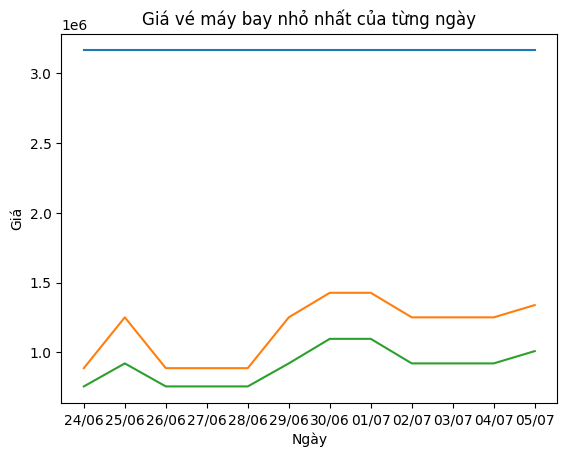

In [182]:
def plot_price(class_):
    min_df = min_price_date(class_)
    min_df['date'] = min_df['Khởi hành'].dt.strftime('%d/%m')
    plt.plot(min_df['date'], min_df[class_])
    plt.title('Giá vé máy bay nhỏ nhất của từng ngày')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')

plot_price('SkyBOSS')
plot_price('Deluxe')
plot_price('Eco')

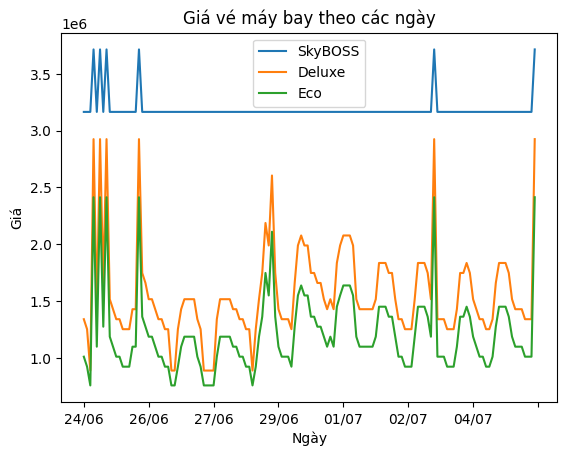

In [ ]:
flight[ticket_class[1:]].set_index(flight['Khởi hành'].dt.strftime('%d/%m')).plot()
plt.title('Giá vé máy bay theo các ngày')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.savefig(path + '/giave.png')